In [136]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
import numpy as np
import pandas as pd
import sys
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer, ngrams_iterator

import nltk

sys.path.append("../")

from utils.model import CBOW_Model
from utils.dataset import CBOW_Dataset, SkipGram_Dataset
from utils.constants import MIN_WORD_FREQUENCY, EMBED_DIMENSION
from utils.trainer import Trainer

In [3]:
with open("../config.yaml", "r") as stream:
    config = yaml.safe_load(stream)

config

{'dataset': 'WikiText2',
 'data_dir': 'data/',
 'train_batch_size': 1000,
 'val_batch_size': 1000,
 'optimizer': 'Adam',
 'learning_rate': 0.025,
 'epochs': 10,
 'train_steps': None,
 'val_steps': None,
 'checkpoint_frequency': None,
 'model_dir': 'weights/cbow_adam_WikiText2_embed_layer'}

In [29]:
folder = "weights/cbow_adam_WikiText2_embed_layer"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(f"../{folder}/cbow_model.pt", map_location=device)
vocab = torch.load(f"../{folder}/vocab.pt")

In [30]:
# first matrix
embeddings_raw = list(model.parameters())[0]
embeddings_raw = embeddings_raw.cpu().detach().numpy().T
embeddings = embeddings_raw / ((embeddings_raw ** 2).sum(axis=0) ** (1 / 2))
embeddings.shape

(300, 4122)

In [31]:
for parameters in model.parameters():
    print(parameters.shape)

torch.Size([4122, 300])
torch.Size([4122, 300])
torch.Size([4122])


## Similar words

In [33]:
main_word_id = vocab["father"]

word_vec = embeddings[:, main_word_id]
word_vec = np.reshape(word_vec, (1, len(word_vec)))

dists = np.matmul(word_vec, embeddings).flatten()

print(vocab.lookup_token(main_word_id))
print()
top5 = np.argsort(-dists)[:10]

for word_id in top5:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

father

father: 1.000
mother: 0.309
wife: 0.264
son: 0.255
parents: 0.238
daughter: 0.231
marriage: 0.231
brother: 0.227
sister: 0.215
previous: 0.213


In [94]:
main_word_id = vocab["father"]

word_vec = embeddings[:, main_word_id]
word_vec = np.reshape(word_vec, (1, len(word_vec)))

dists = np.matmul(word_vec, embeddings).flatten()

print(vocab.lookup_token(main_word_id))
print()
top5 = np.argsort(-dists)[:10]

for word_id in top5:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

father

father: 1.000
mother: 0.385
wife: 0.366
son: 0.358
parents: 0.353
friend: 0.347
brother: 0.336
daughter: 0.328
death: 0.318
hornung: 0.307


In [98]:
class CBOW_Model(nn.Module):
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
        )
        self.linear2 = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.linear1(inputs_)
        x = x.mean(axis=1)
        x = self.linear2(x)
        return x

# Clustering

In [43]:
token_tuples = [(token, token_id) for (token, token_id) in vocab.get_stoi().items()]
token_tuples = sorted(token_tuples, key=lambda tup: tup[1])
tokens = [token for (token, token_id) in token_tuples]

df = pd.DataFrame(embeddings.T)
df.index = tokens

In [46]:
from sklearn.cluster import DBSCAN

db_scan = DBSCAN(eps=0.6, metric="cosine", min_samples=5)

In [47]:
res = db_scan.fit_predict(df)
preds = pd.Series(res)
preds.index = tokens
preds.value_counts()

-1     3810
 0      115
 9       45
 6       21
 2       19
 1       13
 12      13
 11      12
 8        9
 5        8
 4        8
 17       6
 18       6
 3        6
 15       6
 16       5
 13       5
 10       5
 14       5
 7        5
dtype: int64

In [62]:
preds[preds == 15]

singles      15
charts       15
chart        15
billboard    15
hot          15
debuted      15
dtype: int64

## Visualization

In [63]:
from sklearn.decomposition import PCA

In [86]:
token_tuples = [(token, token_id) for (token, token_id) in vocab.get_stoi().items()]
token_tuples = sorted(token_tuples, key=lambda tup: tup[1])
tokens = [token for (token, token_id) in token_tuples]

df = pd.DataFrame(embeddings.T)
df.index = tokens

In [71]:
pca = PCA(n_components=2)

df_transformed = pca.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed)
df_transformed.index = tokens

pca.explained_variance_

array([0.02268678, 0.0191039 ], dtype=float32)

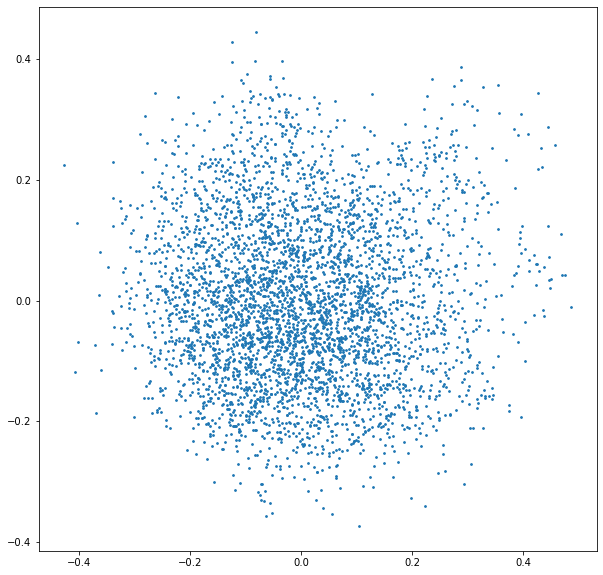

In [72]:
plt.figure(figsize=[10, 10])
plt.scatter(df_transformed[0], df_transformed[1], s=3)

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, early_exaggeration=50)

df_transformed = tsne.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed)
df_transformed.index = tokens

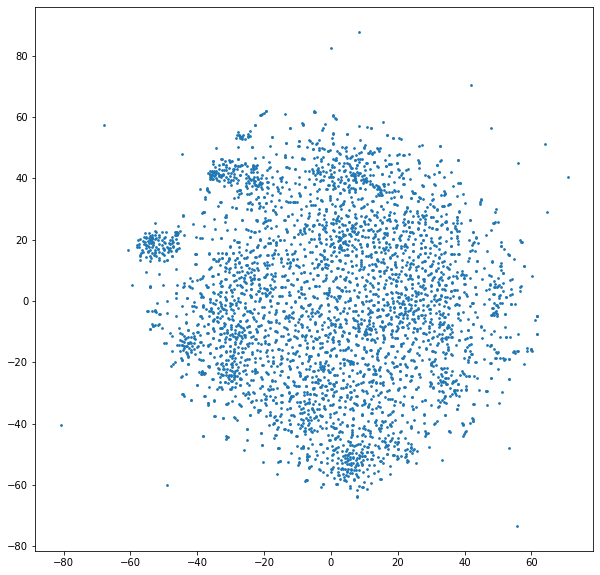

In [93]:
plt.figure(figsize=[10, 10])
plt.scatter(df_transformed[0], df_transformed[1], s=3)

In [89]:
import plotly
import plotly.express as px
from sklearn.decomposition import PCA


fig = px.scatter(df_transformed, x=0, y=1, text=df_transformed.index)
fig.write_html("file.html")

# Similarity

### 1. Over dimensions

In [34]:
token_tuples = [(token, token_id) for (token, token_id) in vocab.get_stoi().items()]
token_tuples = sorted(token_tuples, key=lambda tup: tup[1])
tokens = [token for (token, token_id) in token_tuples]
token_ids = [token_id for (token, token_id) in token_tuples]

tokens = np.array(tokens)

In [37]:
feature_id = 5

feature_embed = embeddings[feature_id, :]

In [38]:
top_ids = np.argsort(-feature_embed)[:10]
tokens[top_ids]

array(['proved', 'completion', 'increasing', 'generated', 'franchise',
       'connection', 'genetic', 'banned', 'fell', 'stood'], dtype='<U15')

### 2. Equation

In [20]:
emb1 = embeddings[:, vocab["leading"]]
emb2 = embeddings[:, vocab["lead"]]
emb3 = embeddings[:, vocab["do"]]

emb4 = emb1 - emb2 + emb3
emb4 = np.reshape(emb4, (1, len(emb4)))
dists = np.matmul(emb4, embeddings).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

do: 0.915
leading: 0.817
did: 0.455
does: 0.428
1939: 0.349


In [3]:
import numpy as np
from collections import Counter
import torch
from torch.utils.data import Dataset
from torchtext.data import to_map_style_dataset
from torchtext.vocab import vocab
from torchtext.datasets import WikiText2, WikiText103

from utils.constants import (
    CBOW_N_WORDS,
    SKIPGRAM_N_WORDS,
    MIN_WORD_FREQUENCY,
    SKIPGRAM_CONTEXT_SAMPLING_POWER,
)


class CBOW_Dataset(Dataset):
    def __init__(self, name, set_type, data_dir, vocab=None):
        self.data_iter = self._get_data_iterator(name, set_type, data_dir)
        self.tokens = self._get_tokens_from_iterator(self.data_iter)
        if vocab != None:
            self.vocab = vocab
        else:
            self.vocab = self._build_vocabulary(self.tokens)
        self.vocab_size = len(self.vocab.get_stoi())

    def _get_data_iterator(self, dataset_name, set_type, data_dir):
        if dataset_name == "WikiText2":
            data_iter = WikiText2(root=data_dir, split=(set_type))
        elif dataset_name == "WikiText103":
            data_iter = WikiText103(root=data_dir, split=(set_type))
        else:
            raise ValueError("Choose dataset from: WikiText2, WikiText103")
        data_iter = to_map_style_dataset(data_iter)
        return data_iter

    def _get_tokens_from_iterator(self, data_iter):
        tokens = []
        for line in data_iter:
            line_lower = line.lower()
            tokens += line_lower.split()
        return tokens

    def _build_vocabulary(self, tokens):
        tokens_counter = Counter(tokens)
        vocabulary = vocab(tokens_counter, min_freq=MIN_WORD_FREQUENCY)
        vocabulary.set_default_index(vocabulary["<unk>"])
        return vocabulary

    def __len__(self):
        return len(self.tokens) - CBOW_N_WORDS * 2

    def __getitem__(self, idx):
        token_sequence = self.tokens[idx : (idx + CBOW_N_WORDS * 2 + 1)]
        token_id_sequence = self.vocab(token_sequence)
        output = token_id_sequence.pop(CBOW_N_WORDS)
        inputs = token_id_sequence

        output = torch.tensor(output, dtype=torch.long)
        inputs = torch.tensor(inputs, dtype=torch.long)
        return inputs, output

In [4]:
data_iter = WikiText2(root="../data/", split=("train"))

In [9]:
for data in data_iter:
    print(data)
    break

 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Character designer <unk> Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by May 'n . 



" The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Character designer <unk> Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by May 'n . \n"

In [ ]:
import torch.nn as nn

from utils.constants import EMBED_DIMENSION


class CBOW_Model(nn.Module):
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x

In [ ]:
data.split()

In [12]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [180]:
from torchtext.data.utils import get_tokenizer
from torchtext.data import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data import DataLoader
from torchtext.datasets import WikiText2


from utils.constants import CBOW_N_WORDS, MIN_WORD_FREQUENCY, MAX_SEQUENCE_LENGTH


def get_english_tokenizer():
    """
    Documentation:
    https://pytorch.org/text/stable/_modules/torchtext/data/utils.html#get_tokenizer
    """
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer


def get_data_iterator(ds_name, ds_type, data_dir):
    if ds_name == "WikiText2":
        data_iter = WikiText2(root=data_dir, split=(ds_type))
    elif ds_name == "WikiText103":
        data_iter = WikiText103(root=data_dir, split=(ds_type))
    else:
        raise ValueError("Choose dataset from: WikiText2, WikiText103")
    data_iter = to_map_style_dataset(data_iter)
    return data_iter


def build_vocab(data_iter, tokenizer):
    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"],
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab


def collate_batch_cbow(batch):
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens = tokenizer(text)
        text_tokens_ids = vocab(text_tokens)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def get_dataloader(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
):

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)

    if model_name == "cbow":
        collate_fn = collate_batch_cbow
    else:
        raise ValueError("Choose model from: cbow, skipgram")

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,
    )
    return dataloader

In [ ]:
from torch.utils.data import DataLoader
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
text_pipeline = lambda x: tokenizer(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = get_tokenizer("basic_english")
train_iter = WikiText2(root="../data", split="train")


def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


tokenizer = get_tokenizer("basic_english")
text_pipeline = lambda x: vocab(tokenizer(x))





train_iter = WikiText2(root="../data", split="train")
dataloader = DataLoader(
    train_iter, batch_size=6, shuffle=False, collate_fn=collate_batch
)

In [23]:
from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS

from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x.lower()))
label_pipeline = lambda x: int(x) - 1


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = WikiText2(root='../data', split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

In [20]:
for batch in train_iter:
    break

In [21]:
batch

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [22]:
collate_batch([batch, batch])

(tensor([2, 2]),
 tensor([15874,  1072,   854,  1310,  4250,    13,    27,    14,    27,    15,
           929,   797,   320, 15874,    98,     3, 27657,    28,     5,  4459,
            11,   564, 52790,     8, 80617,  2125,     7,     2,   525,   241,
             3,    28,  3890, 82814,  6574,    10,   206,   359,     6,     2,
           126,     1, 15874,  1072,   854,  1310,  4250,    13,    27,    14,
            27,    15,   929,   797,   320, 15874,    98,     3, 27657,    28,
             5,  4459,    11,   564, 52790,     8, 80617,  2125,     7,     2,
           525,   241,     3,    28,  3890, 82814,  6574,    10,   206,   359,
             6,     2,   126,     1]),
 tensor([ 0, 42]))

In [73]:
from torch.utils.data import DataLoader
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
text_pipeline = lambda x: tokenizer(x)


def collate_batch(batch):
    inputs_all, output_all, all_texts = [], [], []
    for (_, _text) in batch:
        all_texts.append(_text)
        text_tokens_ids = text_pipeline(_text)
        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            inputs = token_id_sequence
            inputs_all.append(inputs)
            output_all.append(output)

    # label_list = torch.tensor(label_list, dtype=torch.long)
    # text_list = torch.tensor(text_list, dtype=torch.long)

    return np.array(inputs_all), np.array(output_all), all_texts


train_iter = WikiText2(root="../data", split="train")
dataloader = DataLoader(
    train_iter, batch_size=6, shuffle=False, collate_fn=collate_batch
)

In [78]:
data = next(train_iter)
data

" The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Character designer <unk> Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by May 'n . \n"

In [115]:
from torch.utils.data import DataLoader
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
text_pipeline = lambda x: tokenizer(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = get_tokenizer("basic_english")
train_iter = WikiText2(root="../data", split="train")


def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


tokenizer = get_tokenizer("basic_english")
text_pipeline = lambda x: vocab(tokenizer(x))
MAX_SEQUENCE_LENGTH = 200


def collate_batch(batch):
    batch_input, batch_output, batch_text = [], [], []
    for paragraph in batch:
        text_tokens_ids = text_pipeline(paragraph)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]
    

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

        batch_text.append(paragraph)
    return np.array(batch_input), np.array(batch_output), batch_text


train_iter = WikiText2(root="../data", split="train")
dataloader = DataLoader(
    train_iter, batch_size=6, shuffle=False, collate_fn=collate_batch
)

In [114]:
vocab(["hello", "world"])

[0, 96]

In [116]:
for batch in dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

skipping
skipping
skipping
truncating 123
truncating 93
truncating 103
(295, 8)
(295,)


In [117]:
idx = 114

print("Input:", batch[0][idx])
print("Output:", batch[1][idx])

Input: [   34 13620   120     1  1063     0 14742     3]
Output: 2321


In [98]:
batch[2]

[' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Character designer <unk> Honjo

In [112]:
np.array(tokenizer(batch[2][0]))

array(['senjō', 'no', 'valkyria', '3', '<unk>', 'chronicles', '(',
       'japanese', '戦場のヴァルキュリア3', ',', 'lit', '.', 'valkyria', 'of',
       'the', 'battlefield', '3', ')', ',', 'commonly', 'referred', 'to',
       'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', ',',
       'is', 'a', 'tactical', 'role', '@-@', 'playing', 'video', 'game',
       'developed', 'by', 'sega', 'and', 'media', '.', 'vision', 'for',
       'the', 'playstation', 'portable', '.', 'released', 'in', 'january',
       '2011', 'in', 'japan', ',', 'it', 'is', 'the', 'third', 'game',
       'in', 'the', 'valkyria', 'series', '.', '<unk>', 'the', 'same',
       'fusion', 'of', 'tactical', 'and', 'real', '@-@', 'time',
       'gameplay', 'as', 'its', 'predecessors', ',', 'the', 'story',
       'runs', 'parallel', 'to', 'the', 'first', 'game', 'and', 'follows',
       'the', 'nameless', ',', 'a', 'penal', 'military', 'unit',
       'serving', 'the', 'nation', 'of', 'gallia', 'during', 'the',
       'second'